NLP_TwitterBrexit

we first need to download the required packages and then we import the libraries we going to use.

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import os
import tweepy as tw
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
import re
import string
from unidecode import unidecode

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer


import preprocessor as p
from typing import List
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import tokenize

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

from textblob import TextBlob

import sys
sys.path.insert(0, '../config')

from twitter_dev_access import *


# Global Parameters
stop_words = set(stopwords.words('english'))

# amount of tweets collected is tweets_per_page * no_of_pages 
# note that retweets will be directly removed, but are still considered to this number
tweets_per_page = 100 # max 200
no_of_pages = 12

In [3]:
# access twitter
# NB: You should have a twitter developer account, then you need to use your crediencials
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [4]:
# A list of recently active politician from both the consevatives ad Labour parties (source: https://members.parliament.uk/)
conservatives = ['@BorisJohnson', '@theresa_may']
conservative_house_of_commons = ['@nadams', '@BimAfolami', '@AdamAfriyie', '@imranahmadkhan', '@peter_aldous',
                                 '@lucyallan', '@amessd_southend', '@Stuart4WolvesSW', '@Caroline_Ansell',
                                 '@AthertonNWales', '@GarethBaconMP', '@richardbaconmp', '@KemiBadenoch',
                                 '@ShaunBaileyUK', '@Siobhan_Baillie']
conservatives.extend(conservative_house_of_commons)
labour = ['@HackneyAbbott', '@Debbie_abrahams', '@rushanaraali', '@TahirAliMP', '@DrRosena', '@MikeAmesburyMP',
          '@PutneyFleur', '@ToniaAntoniazzi', '@JonAshworth', '@PaulaBarkerMP', '@ApsanaBegumMP', '@hilarybennmp',
          '@_OliviaBlake', '@PaulBlomfieldMP', '@TracyBrabin', '@BenPBradshaw', '@KevinBrennanMP', '@lynbrownmp']

In [5]:
def collect_tweets(twitterusers):
    tweet_list = []

    for twitter_name in twitterusers:
        print('collecting tweets from ' + twitter_name)
        
        # get tweets for user, exlude retweets and get full tweet content
        pages = tw.Cursor(api.user_timeline, screen_name=twitter_name, include_rts=False, tweet_mode="extended",
                          count=tweets_per_page).pages(no_of_pages)
        
        # get tweets from pages
        tweet_texts = [tweet.full_text for page in pages for tweet in page]

        print('Collected ' + str(len(tweet_texts)) + ' tweets from ' + twitter_name)

        # only add newest 100 tweets to tweet list
        tweet_list.extend(tweet_texts[:1000])
    
    print('All tweets collected for this party: '+ str(len(tweet_list)))
    
    return tweet_list

In [6]:
# first way of preprocessing the tweets (not going to use this one)
def tweet_preprocessor(tweets: List[str])->List[str]:
    tweets_cleaned = []
    for tweet in tweets :
        tweets_cleaned.append(p.clean(tweet))
        
    return tweets_cleaned

def listToString(s):  
    str1 = ""  
    
    for ele in s:  
        str1 += ele   
    
    return str1  

In [7]:
# Custom data cleaning
def clean(tweet, method='stemming'):
    tweet = tweet.lower()
    
    # Remove unicode characters (emotes etc)
    tweet = unidecode(tweet)
    
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove html encodings like &amp;
    tweet = re.sub(r'&\w+;','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    # use stemmer
    if method=='stemming':
        ps = PorterStemmer()
        stemmed_words = [ps.stem(w) for w in filtered_words]
    
        return " ".join(stemmed_words)
    elif method=='lemmantization':
        lemmantizer = WordNetLemmatizer()
        lemm_words = [lemmantizer.lemmatize(w) for w in filtered_words]
        return " ".join(lemm_words)
    else :
        print('Error ! please provide a correct method')
    

In [8]:

def store(tweet_list, filename):
    with open(filename, 'w') as f:
        for tweet in tweet_list:
            f.write("%s\n" % tweet)
    print(f"saved tweets to {filename}")

In [9]:
# skraping the tweets (we aim for 8000-10000)
conservatives_tweets = collect_tweets(conservatives)

collecting tweets from @BorisJohnson
Collected 872 tweets from @BorisJohnson
collecting tweets from @theresa_may
Collected 687 tweets from @theresa_may
collecting tweets from @nadams
Collected 673 tweets from @nadams
collecting tweets from @BimAfolami
Collected 321 tweets from @BimAfolami
collecting tweets from @AdamAfriyie
Collected 1189 tweets from @AdamAfriyie
collecting tweets from @imranahmadkhan
Collected 633 tweets from @imranahmadkhan
collecting tweets from @peter_aldous
Collected 819 tweets from @peter_aldous
collecting tweets from @lucyallan
Collected 788 tweets from @lucyallan
collecting tweets from @amessd_southend
Collected 965 tweets from @amessd_southend
collecting tweets from @Stuart4WolvesSW
Collected 615 tweets from @Stuart4WolvesSW
collecting tweets from @Caroline_Ansell
Collected 570 tweets from @Caroline_Ansell
collecting tweets from @AthertonNWales
Collected 860 tweets from @AthertonNWales
collecting tweets from @GarethBaconMP
Collected 269 tweets from @GarethBaco

In [10]:
print(conservatives_tweets[:5])

['More than 8 million people across the United Kingdom have now received their first vaccine dose.\n\nThank you to everyone who has come forward to get their jab. https://t.co/Li9Noc3Lxv', 'I want to say a huge thank you to the parents, carers and guardians of children. \n\nMillions of you have coped with the pressures of home schooling and childcare while also doing your day jobs. And by staying at home you are, quite literally, saving lives. https://t.co/m6NSyAPITl', 'It was the highlight of my day to virtually drop in on the Year 6 class of St Joseph’s Catholic Primary School, Upminster.\n\nI’m in awe of the way teachers, parents, guardians and carers have risen to the unique challenges of the pandemic. I quite simply cannot thank you enough. https://t.co/uoF7fsxIG6', 'Very encouraging that early trials of the vaccine developed by Janssen show it to be effective against coronavirus.\n\nWe have secured 30 million doses, and if approved by our medicines regulator we should expect thes

In [11]:
# we can expiriment we either stemming or lemmantization
cleaned_conservative = [clean(tweet, method='lemmantization') for tweet in conservatives_tweets]

In [12]:
print(cleaned_conservative)

['8 million people across united kingdom received first vaccine dose thank everyone come forward get jab', 'want say huge thank parent carers guardian child million coped pressure home schooling childcare also day job staying home quite literally saving life', 'highlight day virtually drop year 6 class st joseph catholic primary school upminster im awe way teacher parent guardian carers risen unique challenge pandemic quite simply thank enough', 'encouraging early trial vaccine developed janssen show effective coronavirus secured 30 million dos approved medicine regulator expect available later year', 'yesterday visited scotland see uk government supporting scottish government colleague beat pandemic im immensely grateful working deliver test vaccine together stop spread coronavirus', 'scotland met brilliant healthcare worker scientist military personnel coordinating pandemic response uk government working hard support part uk delivering vaccine test unprecedented rate', 'good news vac

In [13]:
store(cleaned_conservative, "conservative_tweets_preprocessed.txt")


saved tweets to conservative_tweets_preprocessed.txt


In [14]:
# A function that returns the 10 most frequent Words in (Labour or conservative) tweets

import re
from collections import Counter

#getting top 10 frequent words
def top10(tweets):
    list_of_words = []
    for tweet in tweets:
        words = re.findall(r'\w+', tweet)
        list_of_words.append(words)
    flat_list = [item for sublist in list_of_words for item in sublist]

    word_counts = Counter(flat_list)
    return word_counts.most_common(10)
    
    


In [15]:
top10_conservatives = top10(cleaned_conservative)
print(top10_conservatives)

[('today', 1131), ('people', 1079), ('great', 899), ('support', 872), ('work', 806), ('business', 726), ('thank', 715), ('year', 709), ('uk', 639), ('get', 611)]


In [16]:
# collection Labour party members' tweets
labour_tweets = collect_tweets(labour)

collecting tweets from @HackneyAbbott
Collected 724 tweets from @HackneyAbbott
collecting tweets from @Debbie_abrahams
Collected 747 tweets from @Debbie_abrahams
collecting tweets from @rushanaraali
Collected 308 tweets from @rushanaraali
collecting tweets from @TahirAliMP
Collected 256 tweets from @TahirAliMP
collecting tweets from @DrRosena
Collected 776 tweets from @DrRosena
collecting tweets from @MikeAmesburyMP
Collected 223 tweets from @MikeAmesburyMP
collecting tweets from @PutneyFleur
Collected 789 tweets from @PutneyFleur
collecting tweets from @ToniaAntoniazzi
Collected 584 tweets from @ToniaAntoniazzi
collecting tweets from @JonAshworth
Collected 503 tweets from @JonAshworth
collecting tweets from @PaulaBarkerMP
Collected 427 tweets from @PaulaBarkerMP
collecting tweets from @ApsanaBegumMP
Collected 652 tweets from @ApsanaBegumMP
collecting tweets from @hilarybennmp
Collected 446 tweets from @hilarybennmp
collecting tweets from @_OliviaBlake
Collected 657 tweets from @_Olivi

In [17]:
cleaned_labour = [clean(tweet, 'lemmantization') for tweet in labour_tweets]

In [18]:
top10_labour = top10(cleaned_labour)
print(top10_labour)

[('government', 1058), ('support', 964), ('people', 898), ('need', 811), ('today', 699), ('thanks', 656), ('must', 598), ('please', 574), ('many', 557), ('year', 545)]


In [19]:
store(cleaned_labour, "labour_tweets_preprocessed.txt")


saved tweets to labour_tweets_preprocessed.txt


In [20]:
import matplotlib.pyplot as plt 

def plot_co_occurence(word_frequencies, title="most frequent words"):
    items = sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:15]
    words = [w[0] for w in items]
    counts = [w[1] for w in items]
    x_pos = np.arange(len(words)) 

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    ax = sns.set_context("notebook", font_scale=3.25, rc={"lines.linewidth": 2.5})
    ax = sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    figure = ax.get_figure()    
    figure.savefig('co_occurence', bbox_inches='tight')

R:\Programs\Anaconda\envs\tensor\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


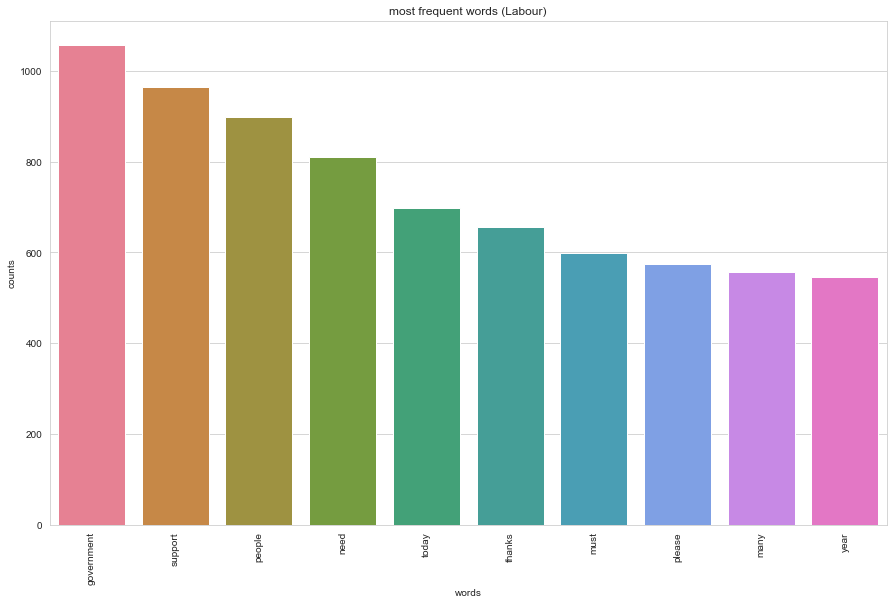

R:\Programs\Anaconda\envs\tensor\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


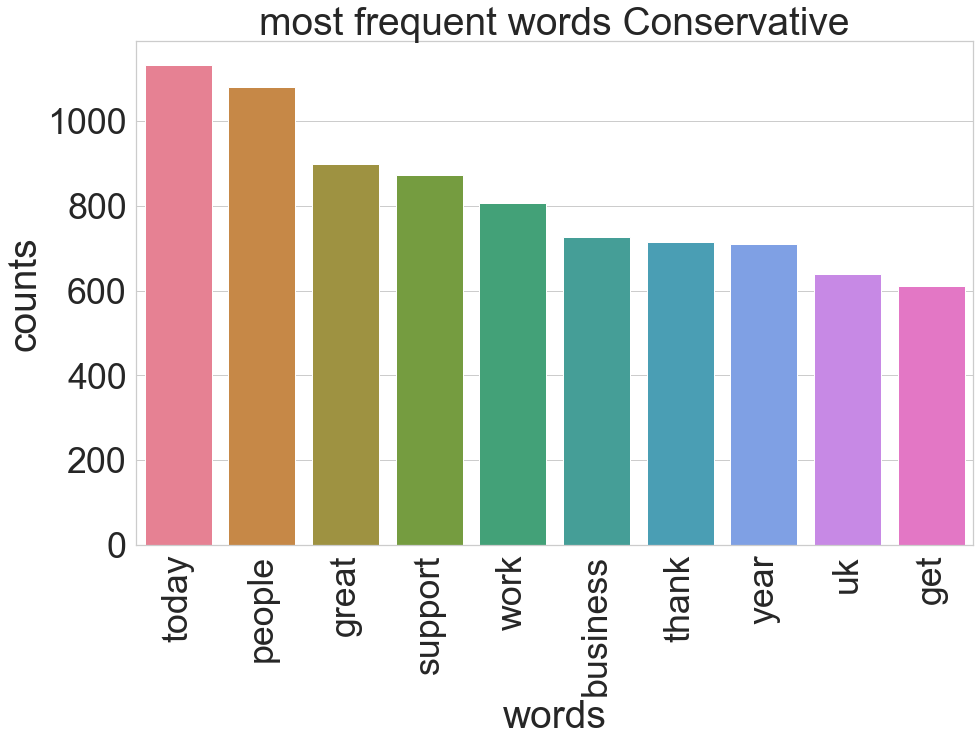

In [21]:
# Here we plot our findings 
plot_co_occurence(dict(top10_labour), 'most frequent words (Labour)')

plot_co_occurence(dict(top10_conservatives), 'most frequent words Conservative')

In [22]:
def load(filename):
    tweet_list = []
    with open(filename, 'r') as f:
        for tweet in f:
            tweet_list.append(tweet.strip())
            
    print(f"loaded tweets from {filename}")
    return tweet_list

In [23]:
cleaned_conservatives_tweets = load("conservative_tweets_preprocessed.txt")
cleaned_labour_tweets = load("labour_tweets_preprocessed.txt")

loaded tweets from conservative_tweets_preprocessed.txt
loaded tweets from labour_tweets_preprocessed.txt


***
we  first  started  by  comparing  the  10  most  frequent  words in each  document as  illustrated above. Then, we  measure  the  similarity  coefficient  of  these  vectors  by calculating the Jacquard similarity.
***

In [24]:
top10_conservative_wordset = set([word[0] for word in top10_conservatives])
top10_labour_wordset = set([word[0] for word in top10_labour])

jaccard_index_top10 = nltk.jaccard_distance(top10_conservative_wordset, top10_labour_wordset)

print('Jaccard distance based on TOP10 most frequent words: ' + str(jaccard_index_top10))

Jaccard distance based on TOP10 most frequent words: 0.75


In [25]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer, title):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    ax =sns.set_context("notebook", font_scale=2.25, rc={"lines.linewidth": 2.5})
    ax =sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    figure = ax.get_figure()    
    figure.savefig('to10.png', bbox_inches='tight')
    
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
def get_topic_words(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    topic_words = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words.extend([words[i]for i in topic.argsort()[:-n_top_words - 1:-1]])
    return topic_words

conservative


R:\Programs\Anaconda\envs\tensor\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


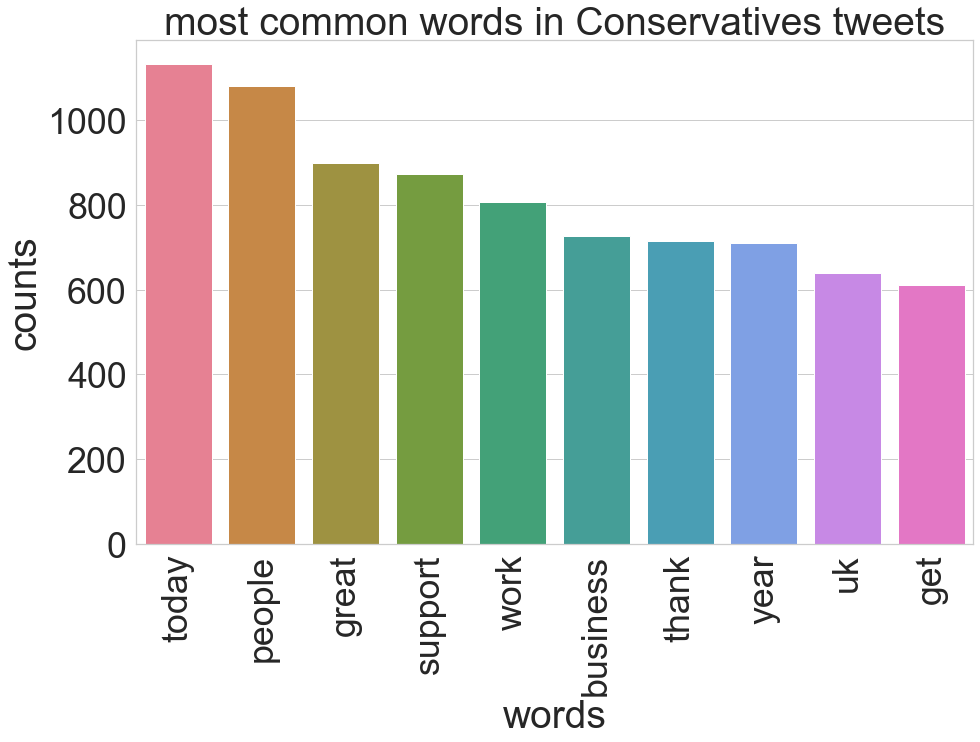

labour


In [27]:
import seaborn as sns
sns.set_style('whitegrid')

# Initialise the count vectorizer with the English stop words
count_vectorizer_conservatives = CountVectorizer()
count_vectorizer_labour = CountVectorizer()
# Fit and transform the processed titles
count_data_conservatives = count_vectorizer_conservatives.fit_transform(cleaned_conservatives_tweets)

# Fit and transform the processed titles
count_data_labour = count_vectorizer_labour.fit_transform(cleaned_labour_tweets)

# Visualise the 10 most common words
print("conservative")
plot_10_most_common_words(count_data_conservatives, count_vectorizer_conservatives, 'most common words in Conservatives tweets')
print('labour')
# plot_10_most_common_words(count_data_labour, count_vectorizer_labour, 'most common words in labour tweets')

***
As  in  fuzzy  clustering,  in  which  each  data  point  or  wordbelongs  to  more  than  one  cluster,  a  document  may  be  partof  multiple  topics.  In  order  to  find  out  what  topics  do  thedocuments  belong   to,  we  used   one  of  the   most  populartopic  modeling  methods,  namely  Latent  Dirichlet  Allocation(LDA). We used a number of topics equal to 5 and a number of words that equals 10
***

In [28]:
# Tweak the two parameters below
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda_conservatives = LDA(n_components=number_topics, n_jobs=-1)
lda_conservatives.fit(count_data_conservatives)

# Print the topics found by the LDA model
print("Topics found via LDA for conservative tweets:")
print_topics(lda_conservatives, count_vectorizer_conservatives, number_words)

# Create and fit the LDA model
lda_labour = LDA(n_components=number_topics, n_jobs=-1)
lda_labour.fit(count_data_labour)

# Print the topics found by the LDA model
print("Topics found via LDA for labour tweets:")
print_topics(lda_labour, count_vectorizer_labour, number_words)

Topics found via LDA for conservative tweets:

Topic #0:
thank people life support today work year help nh coronavirus

Topic #1:
london mayor get need tfl londoner government vote khan people

Topic #2:
uk trade good great done well today brexit new deal

Topic #3:
great local business waveney today thanks see lowestoft work forward

Topic #4:
people today uk country government support new minister great million
Topics found via LDA for labour tweets:

Topic #0:
thank bill government eu today uk brexit great right minister

Topic #1:
people year tory job im labour support work forward great

Topic #2:
thanks please email best hi full many detail address get

Topic #3:
year need today one family business people deal christmas putney

Topic #4:
government support need health must people nh today covid worker


***
Besides this, we have also convert the words into a two-component vector and performed the sentiments analysis usingSentistrength.  The  latter  creates  a  list  of  tuples  representing positive and negative sentiments. Based on these estimations, we calculate the Pearson score for both positive and negative
values  and  delivered  the  respective  results  of  -0.00447  and0.002861. Surprisingly, we noticed almost no correlation; this is  because  the  scores  were  graded  in  an  interval  of  -5  to  5 when using Sentistrenght. However, even using a single vectorof binary flatted values, we observed relatively similar results.
***

In [29]:
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath(os.path.join(os.getcwd(), "SentiStrength.jar"))
senti.setSentiStrengthLanguageFolderPath(os.path.join(os.getcwd(),'SentiStrengthData/'))
# print(os.listdir(os.getcwd()))

# print(type(np.asarray(conservative_tweets)))
corpus1= []
corpus2= []
for tweet in conservatives_tweets:
    corpus1.append(tweet.split())
for tweet in labour_tweets:
    corpus2.append(tweet.split())
    
# flattening the document to get only a list of words
corpus1 = [item for sublist in corpus1 for item in sublist]
corpus2 = [item for sublist in corpus2 for item in sublist]
conservatives_sentiments = senti.getSentiment(conservatives_tweets, score='binary')
labour_sentiments  = senti.getSentiment(labour_tweets, score='binary')


In [30]:
print(np.asarray(labour_sentiments)[:20])
print(np.asarray(conservatives_sentiments)[:20])

[-1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1]
[ 1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1 -1  1]


In [31]:
from scipy.stats import pearsonr

pearson_score = pearsonr( np.asarray(conservatives_sentiments)[0:9000], np.asarray(labour_sentiments)[:9000])
print(f"positive sentiment value is : {pearson_score}")
pearson_score = pearsonr( np.asarray(conservatives_sentiments)[0:9000], np.asarray(labour_sentiments)[:9000])
print(f"negative sentiment value is : {pearson_score}")

positive sentiment value is : (0.009670654712766381, 0.35896823335685185)
negative sentiment value is : (0.009670654712766381, 0.35896823335685185)


***

At this stage, we preprocessed the tweets slightly differently, namely  by  keeping  the  stopwords;  this  had  the  purpose  of influencing  the  parser  positively.  In  order  to  know  the  co-occurring  words  with  the  wordBrexit,  we  split  the  list  of tweets  present  in  each  document  into  a  list  of  sentences  and fed them to ”NLTK part of speech parser” When it comes to verbs,  we  are  only  interested  in  the  closest  one  to  the  word "Brexit".  Consequently,  we  compare  the  indexes  of  verbs  to the  index  of  the  target  word  (Brexit)  in  every  sentence  that contains  more  than  one  verb  and  chose  the  closest  one.  A similar process was applied to adjectives and adverbs too.

***

In [32]:
#let's preprocess the the gathered docments again for the parser tree tagging
def clean2(tweet, method='lemmatization'):
    # from https://www.pluralsight.com/guides/building-a-twitter-sentiment-analysis-in-python
    tweet = tweet.lower()
    
    # Remove unicode characters (emotes etc)
    tweet = unidecode(tweet)
    
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove html encodings like &amp;
    tweet = re.sub(r'&\w+;','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation.replace("'","")))
    
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
#     filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    # use stemmer
    if method=='stemming':
        ps = PorterStemmer()
        stemmed_words = [ps.stem(w) for w in tweet_tokens]
    
        return " ".join(stemmed_words)
    elif method=='lemmatization':
        lemmantizer = WordNetLemmatizer()
        lemm_words = [lemmantizer.lemmatize(w) for w in tweet_tokens]
        return " ".join(lemm_words)
    else :
        print('Error ! please provide a correct method')
        
cleaned_conservative = [clean2(tweet, method='lemmatization') for tweet in conservatives_tweets]
cleaned_labour = [clean2(tweet, method='lemmatization') for tweet in labour_tweets]


In [33]:
# splitting and tagging words from each corpus
doc1_tokens =[]
doc2_tokens =[]
for tweet in cleaned_conservative:
    doc1_tokens.append(word_tokenize(tweet))
    
for tweet in cleaned_labour:
    doc2_tokens.append(word_tokenize(tweet))
doc1_tokens = [item for sublist in doc1_tokens for item in sublist]
doc2_tokens = [item for sublist in doc2_tokens for item in sublist]

tagged1 = nltk.pos_tag(doc1_tokens)
tagged2 = nltk.pos_tag(doc2_tokens)


In [34]:
# for more info about POS tagging check NLTK documentation
print([x[1] for x in tagged1[:20]])

['JJR', 'IN', 'CD', 'CD', 'NNS', 'IN', 'DT', 'JJ', 'NN', 'VBP', 'RB', 'VBN', 'PRP$', 'JJ', 'NN', 'NN', 'NN', 'PRP', 'TO', 'NN']


In [35]:
c = [tokenize.sent_tokenize(tweet) for tweet in conservatives_tweets]
cleaned_conservative = [clean2(tweet, method='lemmatization') for tweet in [item for sublist in c for item in sublist]]
while "" in c:
    c.remove("")
l = [tokenize.sent_tokenize(tweet) for tweet in labour_tweets]
cleaned_labour = [clean2(tweet, method='lemmatization') for tweet in [item for sublist in l for item in sublist]]
while "" in l:
    l.remove("")
print(c[:5])

[['More than 8 million people across the United Kingdom have now received their first vaccine dose.', 'Thank you to everyone who has come forward to get their jab.', 'https://t.co/Li9Noc3Lxv'], ['I want to say a huge thank you to the parents, carers and guardians of children.', 'Millions of you have coped with the pressures of home schooling and childcare while also doing your day jobs.', 'And by staying at home you are, quite literally, saving lives.', 'https://t.co/m6NSyAPITl'], ['It was the highlight of my day to virtually drop in on the Year 6 class of St Joseph’s Catholic Primary School, Upminster.', 'I’m in awe of the way teachers, parents, guardians and carers have risen to the unique challenges of the pandemic.', 'I quite simply cannot thank you enough.', 'https://t.co/uoF7fsxIG6'], ['Very encouraging that early trials of the vaccine developed by Janssen show it to be effective against coronavirus.', 'We have secured 30 million doses, and if approved by our medicines regulator 

In [36]:
def co_occurent_verbs(corpus, keyword, target="VB")->List[str]:
    cooccurenct_words = []
    for sentence in corpus:
        tokens = word_tokenize(sentence)
#         for token in tokens:
#             if token=="internalmarketbill":
#                 tokens.remove(token)
        if keyword in tokens:
            #testing if the senteces contains only one verb
            if Counter([x[1] for x in nltk.pos_tag(tokens)]).get(target)==1:
                tagged = nltk.pos_tag(tokens)
                for e in tagged:
                    if e[1]==target:
                        cooccurenct_words.append(e[0])
#                 for token in tokens:
#                     if nltk.pos_tag([token])[0][1]==target:
#                         cooccurenct_words.append(token)
            elif Counter([x[1] for x in nltk.pos_tag(tokens)]).get(target)!=None and target=="VB":
                tagged = nltk.pos_tag(tokens)
                result = closest_verb(tagged, keyword)
                if result !=None:
                    cooccurenct_words.append(result)
    return cooccurenct_words

def closest_verb(tagged, keyword):
    verbs = []
    words = [x[0] for x in tagged]
    index = words.index(keyword)
    for n, i in enumerate(words):
        if i == keyword:
            words[n] = "null"
            
    tags = [x[1] for x in tagged]
    verb_indecies = np.where(np.asarray(tags) == "VB")[0]

    for e in tagged:
        if e[1]=="VB":
            verbs.append(e[0])
    records = []
    for i in verb_indecies:
        records.append((abs(index-i),i))
    verb = words[min(records)[1]]
    if verb != "null":
        return(verb)

    


Counter({'be': 20, 'get': 3, 'listen': 3, 'do': 3, 'support': 2, 'have': 2, 'dominate': 2, 'brexit': 2, 'block': 2, 'eu': 2, 'stop': 2, 'claim': 1, 'safer': 1, 'governor': 1, 'cost': 1, 'take': 1, 'consult': 1, 'remain': 1, 'find': 1, 'need': 1, 'make': 1, 'prescribe': 1, 'become': 1, 'withdraw': 1, 'push': 1, 'mean': 1, 'build': 1, 'represent': 1, 'account': 1, 'covid19': 1, 'scrap': 1, 'prepare': 1, 'match': 1, 'answer': 1, 'constituent': 1, 'insist': 1, 'talk': 1, 'healthcare': 1, 'end': 1, 'respond': 1, 'secure': 1, 'meet': 1, 'i': 1, 'read': 1, 'drive': 1, 'investigate': 1, 'come': 1, 'wish': 1, 'brit': 1, 'achieve': 1, 'warn': 1, 'fish': 1, 'vital': 1, 'put': 1, 'countenance': 1, 'force': 1, 'know': 1, 'seek': 1, 'anna': 1, 'vote': 1, 'see': 1, 'play': 1})


R:\Programs\Anaconda\envs\tensor\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


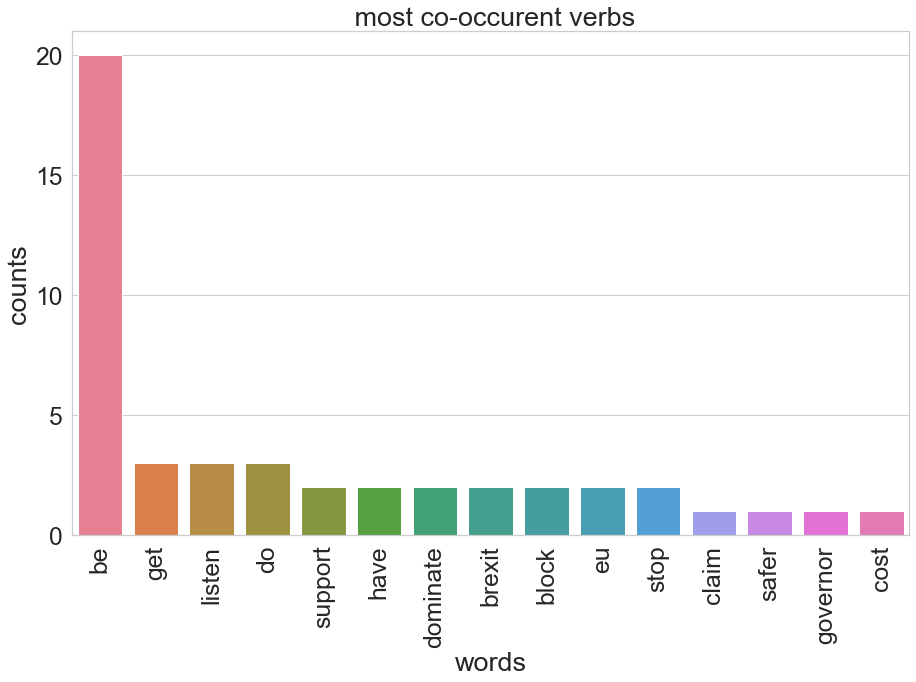

In [37]:
result = Counter(co_occurent_verbs(cleaned_labour, "brexit"))     
print(result)
plot_co_occurence(result, " most co-occurent verbs")

In [38]:
print(len(cleaned_conservative))

24409


Counter({'broken': 4, 'local': 2, 'bad': 2, 'i': 2, 'tory': 2, 'possible': 2, 'govt': 2, 'single': 2, 'great': 1, 'supported': 1, 'andrew': 1, 'creative': 1, 'shamble': 1, 'terrible': 1, 'eu': 1, 'dark': 1, 'ovenready': 1, 'prime': 1, 'good': 1, 'ongoing': 1, 'poor': 1, 'final': 1, 'sexual': 1, 'big': 1, 'indefinite': 1, 'direct': 1, 'virtual': 1, 'public': 1, 'boris': 1, 'small': 1, "'no": 1, 'august': 1, 'last': 1, 'critical': 1, 'desperate': 1, 'main': 1, 'sorry': 1, 'principled': 1, 'january': 1, 'next': 1, 'stupid': 1, 'common': 1, 'fish': 1})


R:\Programs\Anaconda\envs\tensor\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


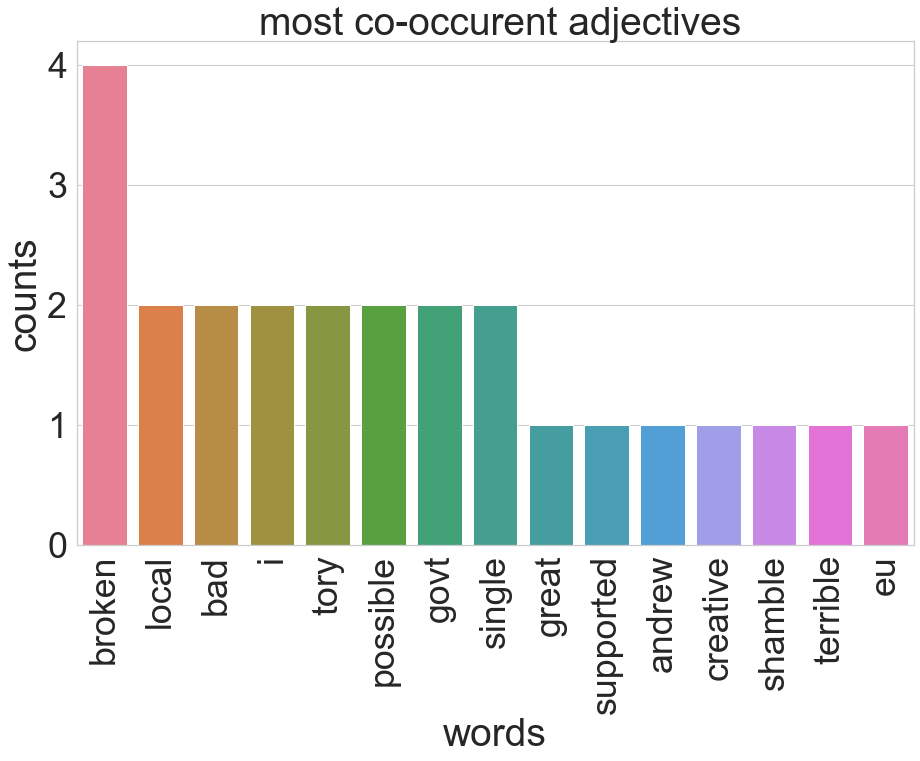

In [39]:
result = Counter(co_occurent_verbs(cleaned_labour, "brexit", "JJ"))     
print(result)
plot_co_occurence(result, " most co-occurent adjectives")

Counter({'sadly': 25, 'consistently': 6, "n't": 5, 'ahead': 5, 'here': 3, 'just': 3, 'not': 3, 'also': 3, 'uk': 2, 'especially': 2, 'right': 2, 'back': 2, 'rather': 2, 'never': 1, 'always': 1, 'already': 1, 'yet': 1, 'even': 1, 'then': 1, 'ah': 1, 'very': 1, 'apparently': 1, 'still': 1, 'only': 1, 'actually': 1, 'well': 1, 'simply': 1, 'further': 1, 'again': 1, 'too': 1, 'punishingly': 1, 'domestically': 1, 'together': 1, 'often': 1, 'so': 1, 'furiously': 1, 'primarily': 1})


R:\Programs\Anaconda\envs\tensor\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


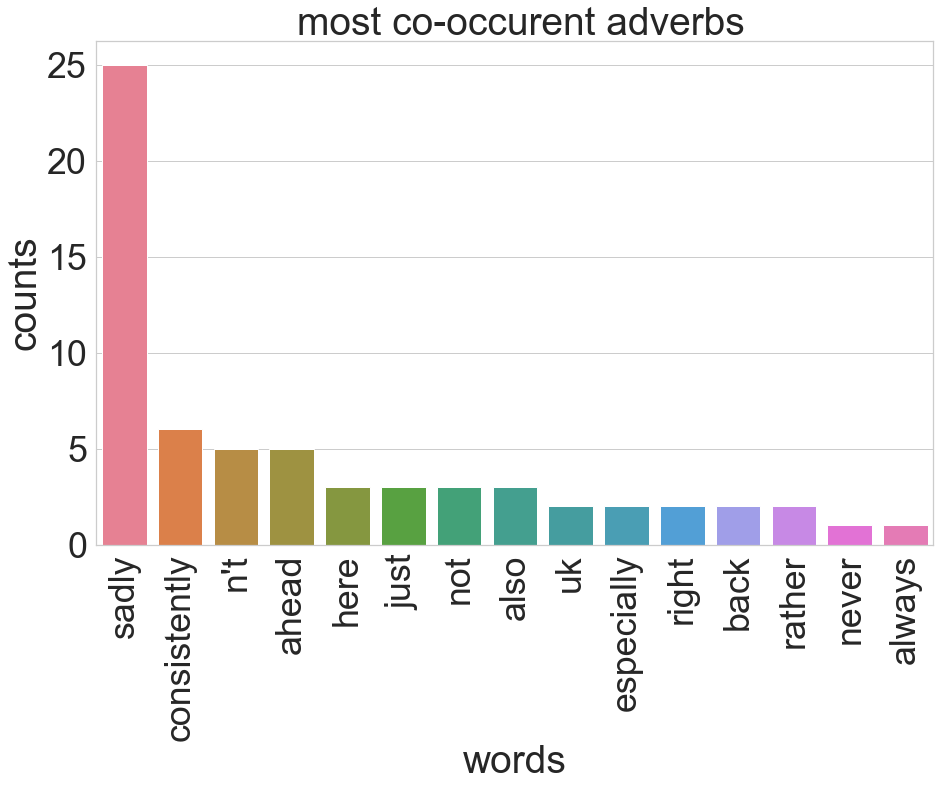

In [40]:
result = Counter(co_occurent_verbs(cleaned_labour, "brexit", "RB"))     
print(result)
plot_co_occurence(result, " most co-occurent adverbs")

***

Once   again,   we   adapted   the   preprocessing   so   it   can differentiate  between  different  forms  of  negation,  especiallythe  contraction  (ex:  ’don’t’  becomes  ’do’  and  ”n’t”  ).  Then,we  counted  the  number  of  operators;  which  are  [’no’,  ’not’,’none’, ’cannot’, ”n’t”] present in each document.


***

In [41]:
#negation operators
negationo_operators=['no', 'not', 'none', 'cannot', "n't"]

#cases where the negation operand is next the the word "BREXIT"
def next_brexit_negation(words):
    index = words.index("brexit")
    c = 0
    for i in words:
        if i in negationo_operators and abs(words.index(i)-index)==1:
            print(i)
            print(words)
            c+=1
        return c

def negation_count(corpus)->int:
    #initalizing a counter for negation operands 
    c = 0
    #initalizing a counter for negation operands coming next to the word "brexit"
    c_next = 0
    for sentence in corpus:
        words = word_tokenize(sentence)
        c += len(set(words) & set(negationo_operators))
        if "brexit" in words:
            c_next += next_brexit_negation(words)
    return c, c_next
n, n_next = negation_count(cleaned_conservative)
print(f'number of negation operand in conservative party tweets is :{n}\
\n number of operand coming next to the word "brexit" is : {n_next}')
n, n_next = negation_count(cleaned_labour)
print(f'number of negation operand in conservative party tweets is :{n}\
\n number of operand coming next to the word "brexit" is : {n_next}')




number of negation operand in conservative party tweets is :1643
 number of operand coming next to the word "brexit" is : 0
number of negation operand in conservative party tweets is :2486
 number of operand coming next to the word "brexit" is : 0


***
From the several available inquirer dictionaries, we used acustom document that contains word classifications according
to the Harvard (”H4”), Lasswell (”Lvd”), or both (”H4Lvd”)dictionaries .  Indeed,  we  categorized  the  words  in  one  of the following categories: positive, negative, affiliation (or supportiveness), hostility, strength, weakness, and model verbs
***

In [42]:
import pandas as pd

'''creating arrys containting different word classification according to the Harvard ("H4"),
Lasswell ("Lvd") or both ("H4Lvd") dictionaries.'''

lexicon = pd.read_excel(os.path.join(os.getcwd(),"inquirerbasic.xls"))

positive_category = lexicon[lexicon.Positiv=='Positiv']
positive_category = positive_category[['Entry']].to_numpy()

negative_category = lexicon[lexicon.Negativ=='Negativ']
negative_category = negative_category[['Entry']].to_numpy()

Affil_category = lexicon[lexicon.Affil=='Affil']
Affil_category = Affil_category[['Entry']].to_numpy()

Hostile_category = lexicon[lexicon.Hostile=='Hostile']
Hostile_category = Hostile_category[['Entry']].to_numpy()

Strong_category = lexicon[lexicon.Strong=='Strong']
Strong_category = Strong_category[['Entry']].to_numpy()

Weak_category = lexicon[lexicon.Weak=='Weak']
Weak_category = Weak_category[['Entry']].to_numpy()

model_verbs = ['may', 'might', 'can', 'could', 'shall', 'should', 'will', 'would', 'must']

#flatning the narrays and removing the NaN values
pattern = r'[#123456789]'

positive_category = [item for sublist in positive_category for item in sublist]
positive_category = [x for x in positive_category if str(x) != 'nan']
positive_category = [re.sub(pattern, '', x.lower()) for x in positive_category]

negative_category = [item for sublist in negative_category for item in sublist]
negative_category = [x for x in negative_category if str(x) != 'nan']
negative_category = [re.sub(pattern, '', str(x).lower()) for x in negative_category]

Affil_category = [item for sublist in Affil_category for item in sublist]
Affil_category = [x for x in Affil_category if str(x) != 'nan']
Affil_category = [re.sub(pattern, '', x.lower()) for x in Affil_category]

Hostile_category = [item for sublist in Hostile_category for item in sublist]
Hostile_category = [x for x in Hostile_category if str(x) != 'nan']
Hostile_category = [re.sub(pattern, '', x.lower()) for x in Hostile_category]

Strong_category = [item for sublist in Strong_category for item in sublist]
Strong_category = [x for x in Strong_category if str(x) != 'nan']
Strong_category = [re.sub(pattern, '', x.lower()) for x in Strong_category]

Weak_category = [item for sublist in Weak_category for item in sublist]
Weak_category = [x for x in Weak_category if str(x) != 'nan']
Weak_category = [re.sub(pattern, '', x.lower()) for x in Weak_category]

In [44]:

def word_classification(corpus: List)->List:
    p = []
    n = []
    a = []
    h = []
    s = []
    w = []
    m = []
    for sentence in corpus:
        words = word_tokenize(sentence)
        for word in words:
            if word in positive_category:
                p.append(word)
            if word in negative_category:
                n.append(word)
            if word in Affil_category:
                a.append(word)
            if word in Hostile_category:
                h.append(word)
            if word in Strong_category:
                s.append(word)
            if word in Weak_category:
                w.append(word)
            if word in model_verbs:
                m.append(word)
    return [p,n,a,h,s,w,m]



In [45]:
c_p,c_n,c_a,c_h,c_s,c_w,c_m = word_classification(cleaned_conservative)

print(f'Conservatives party :\n\tpositive {len(c_p)}  negative {len(c_n)}  affiliation {len(c_a)}  hostile {len(c_h)}\
  string{len(c_s)}  weak {len(c_w)}  model verbs {len(c_m)} words')

l_p,l_n,l_a,l_h,l_s,l_w,l_m = word_classification(cleaned_labour)

print(f'Labour party :\n\tpositive {len(l_p)}  negative {len(l_n)}  affiliation {len(l_a)}  hostile {len(l_h)}\
  string{len(l_s)}  weak {len(l_w)}  model verbs {len(l_m)} words')


Conservatives party :
	positive 23669  negative 10738  affiliation 15641  hostile 6757  string32895  weak 8025  model verbs 3922 words
Labour party :
	positive 19067  negative 11312  affiliation 12796  hostile 6358  string27855  weak 8528  model verbs 3846 words


R:\Programs\Anaconda\envs\tensor\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


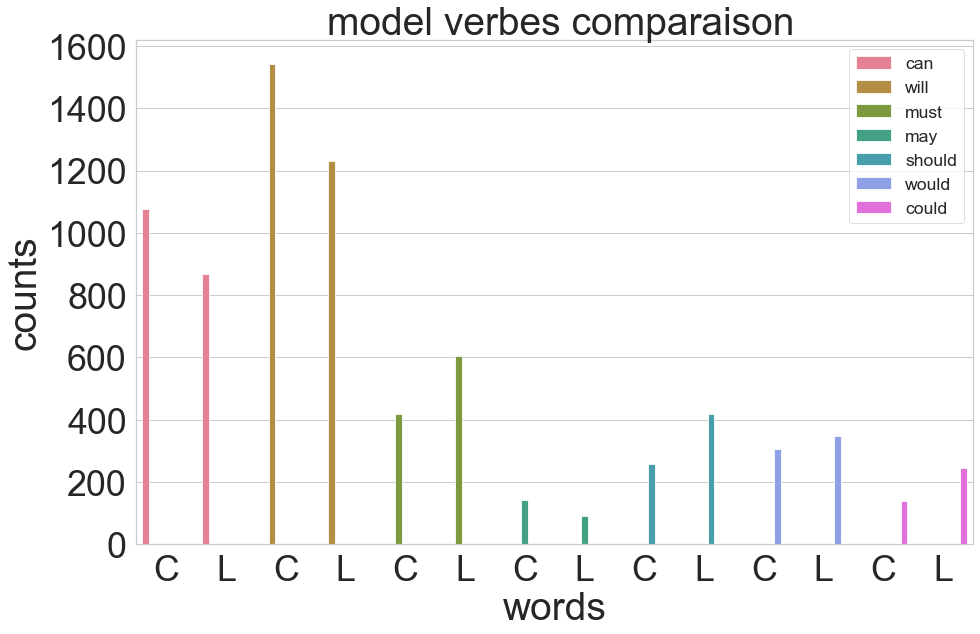

In [46]:
# This Cell has to be rewritten as it isn't very efficient !!

def plot_comparaison(conservatives_frequencies, labour_frequencies, title="most frequent words"):
    convervatives_items = conservatives_frequencies.items()
    labour_items = labour_frequencies.items()

    #items = sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:15]
    convervatives_words = [w[0] for w in conservatives_frequencies.items()]
    convervatives_counts = [w[1] for w in conservatives_frequencies.items()]
    labour_words = [w[0] for w in labour_frequencies.items()]
    labour_counts = [w[1] for w in labour_frequencies.items()]
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)

    c=['c' for x in convervatives_words]
    l=['l' for x in labour_words]
    parties =c+l
    frequencies = convervatives_counts + labour_counts

    can = [w[0] for w in conservatives_frequencies.items() if w[0]=='can']
    can_count= [w[1] for w in conservatives_frequencies.items()if w[0]=='can']
    will = [w[0] for w in conservatives_frequencies.items() if w[0]=='will']
    will_count= [w[1] for w in conservatives_frequencies.items()if w[0]=='will']
    must = [w[0] for w in conservatives_frequencies.items() if w[0]=='must']
    must_count= [w[1] for w in conservatives_frequencies.items()if w[0]=='must']
    may = [w[0] for w in conservatives_frequencies.items() if w[0]=='may']
    may_count= [w[1] for w in conservatives_frequencies.items()if w[0]=='may']
    should = [w[0] for w in conservatives_frequencies.items() if w[0]=='should']
    should_count= [w[1] for w in conservatives_frequencies.items()if w[0]=='should']
    would = [w[0] for w in conservatives_frequencies.items() if w[0]=='would']
    would_count= [w[1] for w in conservatives_frequencies.items()if w[0]=='would']
    could = [w[0] for w in conservatives_frequencies.items() if w[0]=='could']
    could_count= [w[1] for w in conservatives_frequencies.items()if w[0]=='could']
    
    can_l = [w[0] for w in labour_frequencies.items() if w[0]=='can']
    can_count_l= [w[1] for w in labour_frequencies.items()if w[0]=='can']
    will_l = [w[0] for w in labour_frequencies.items() if w[0]=='will']
    will_count_l= [w[1] for w in labour_frequencies.items()if w[0]=='will']
    must_l = [w[0] for w in labour_frequencies.items() if w[0]=='must']
    must_count_l= [w[1] for w in labour_frequencies.items()if w[0]=='must']
    may_l = [w[0] for w in labour_frequencies.items() if w[0]=='may']
    may_count_l= [w[1] for w in labour_frequencies.items()if w[0]=='may']
    should_l = [w[0] for w in labour_frequencies.items() if w[0]=='should']
    should_count_l= [w[1] for w in labour_frequencies.items()if w[0]=='should']
    would_l = [w[0] for w in labour_frequencies.items() if w[0]=='would']
    would_count_l= [w[1] for w in labour_frequencies.items()if w[0]=='would']
    could_l = [w[0] for w in labour_frequencies.items() if w[0]=='could']
    could_count_l= [w[1] for w in labour_frequencies.items()if w[0]=='could']
    

    frequencies = can_count+can_count_l+will_count+will_count_l+must_count+must_count_l+may_count+may_count_l+\
    should_count+should_count_l+would_count+would_count_l+could_count+could_count_l
    parties = can+can_l+will+will_l+must+must_l+may+may_l+should+should_l+would+would_l+could+could_l
    x_pos = np.arange(len(parties))
    
    print(" ")

    x = ["C","L","C","L","C","L","C","L","C","L","C","L","C","L","C","L"]
    ax = sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 3.5})
    ax = sns.barplot(x_pos, frequencies,hue=parties, palette='husl')
    plt.xticks(x_pos, x) 
    plt.xlabel('words')
    plt.ylabel('counts')
    figure = ax.get_figure()    
    figure.savefig('H4', bbox_inches='tight')
    
    #plt.hist([convervatives_counts, labour_counts], bins = int(180/15))
    
    plt.show()

cm_count = Counter(c_m)
lm_count = Counter(l_m)     

plot_comparaison(cm_count, lm_count, " model verbes comparaison")